# Laser Scanning Confocal Microscopy
Esta es la técnica usada para obtener las imágenes. Se puede ver un video muy lindo del funcionamiento en la página de Wikipedia [Confocal microscopy](https://en.wikipedia.org/wiki/Confocal_microscopy). También ayuda a enternder cómo se hace el slicing en $z$ el ver en el diagrama de rayos cómo los de otros planos focales son bloqueados by the pin hole:

<img src="https://github.com/JeroFotinos/experimental_image_analysis/raw/main/confocal_microscopy_z_slicing.png" alt="Z slicing in confocal microscopy" style="width: 600px;"/>

In [ ]:
#@title Mounting Drive and Installing Packages

# Are we using Colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# If so, connect to Google account and install needed packages
if IN_COLAB:
    # We mount the drive
    from google.colab import drive
    drive.mount('/content/drive')
    ! ls drive/MyDrive/datasets/

    # We install the packages
    ! pip install czifile
    ! python -m pip install "napari[all]"
    ! python -m pip install -U scikit-image
    ! pip install pyclesperanto-prototype
    ! pip install lxml
    ! pip install stardist



Mounted at /content/drive
'ESTA - Sph1 Z Stack - CTRL SOX2.czi'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.9/123.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.6/601.6 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/

In [ ]:
! ls drive/MyDrive/datasets/

'ESTA - Sph1 Z Stack - CTRL SOX2.czi'


In [ ]:
# import zipfile

# archivo_zip = "drive/MyDrive/datasets/supervisado-diplodatos2023.zip"
# with zipfile.ZipFile(archivo_zip, 'r') as zip_ref:
#     zip_ref.extractall()

In [ ]:
#@title Imports

# General Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Opening Images Imports
import czifile
from pathlib import Path
from lxml import etree


# Visualizing Images Imports
import napari
from napari.utils import nbscreenshot


# Filtering Images Imports
import skimage
from skimage import morphology
from skimage import img_as_float
from skimage import exposure
from skimage import filters
from skimage.morphology import reconstruction, disk, white_tophat, square, opening
from skimage.restoration import rolling_ball, denoise_bilateral
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, regionprops_table

from scipy.ndimage import gaussian_filter
from pyclesperanto_prototype import imshow


# Image Segmentation Imports
from stardist.models import StarDist2D
from skimage.segmentation import find_boundaries

# Teselation Imports
from scipy.spatial import Voronoi, voronoi_plot_2d, distance



# Opening the Image
## Loading the CZI object
Las imágenes vienen in a proprietary format called CZI, que pertenece a la empresa que hace el microscopio (Zeiss). Para trabajar con estos archivos, hay una biblioteca específica llamada `czifile`. Los metadatos asociados se encuentran en formato XML en el CZI. Para parsearlo uso `lxml`, la biblioteca más completa para trabajar con XML. En particular, brinda soporte para trabajar con XPath, un lenguaje para realizar consultas a archivos XML (it's a query language for navigatin XML documents).

Napari uses Qt for Graphical User Interface (GUI) so we must first create the Qt application before we can get started with `napari`.

In [ ]:
if not IN_COLAB:
  %gui qt

In [ ]:
# Instantiate a Path object
if IN_COLAB:
  czi_file_path = Path(r"drive/MyDrive/datasets/ESTA - Sph1 Z Stack - CTRL SOX2.czi")
else:
  czi_file_path = Path(r"./ESTA - Sph1 Z Stack - CTRL SOX2.czi")

# Read the image and get the CziFile object
with czifile.CziFile(czi_file_path) as czi:
    img = czi.asarray()  # Store image data in 'img' variable
    czi_object = czi  # Store the CziFile object

    # Extract a string containing the XML metadata
    metadata_xml_str = czi.metadata()
    # If you want the metadata as a dictionary instead of XML, you can use
    # metadata_dict = czi.metadata(raw=False)

    metadata_tree = etree.fromstring(metadata_xml_str.encode('utf-8'))

    # Save the metadata to an XML file
    with open('metadata.xml', 'wb') as f:
        f.write(etree.tostring(metadata_tree, pretty_print=True))


In [ ]:
# We can see that the array has 8 dimensions
img.shape

(1, 1, 3, 1, 9, 2292, 2292, 1)

In [ ]:
# We can get the shape from the array or from the czi object
czi_shapeinfo = czi.shape
czi_shapeinfo

(1, 1, 3, 1, 9, 2292, 2292, 1)

To know what is what, we look at the `axes` string attribute, and interpret it according to the Information CZI Dimension Characters:
```python
- '0': 'Sample',  # e.g. RGBA
- 'X': 'Width',
- 'Y': 'Height',
- 'C': 'Channel',
- 'Z': 'Slice',  # depth
- 'T': 'Time',
- 'R': 'Rotation',
- 'S': 'Scene',  # contiguous regions of interest in a mosaic image
- 'I': 'Illumination',  # direction
- 'B': 'Block',  # acquisition
- 'M': 'Mosaic',  # index of tile for compositing a scene
- 'H': 'Phase',  # e.g. Airy detector fibers
- 'V': 'View',  # e.g. for SPIM
```

In [ ]:
# axes will give a string describing them
czi_dimstring = czi.axes
czi_dimstring

'BVCTZYX0'

So, according to this, `img` is an array of:
- B = 1, so one block
- V = 1, so one view
- C = 3, so three channels (which makes sense, they are the optic channel, the one indicating the nuclei and the SOX2 channel)
- T = 1, so a single time frame (i.e. no $t$ component)
- Z = 9, so 9 $z$ slices
- Y = 2292, so we have that many pixels in the $y$ direction (height)
- X = 2292, idem (note that we have a square image)
- '0' = 1, indicating that we have a single sample

## Dealing with the XML Metadata
Primero intenté navegar el XML de manera simple con `pandas`, pero no anduvo, así que tuve que parsear a mano con `lxml`.

In [ ]:
# We define functions for parsing
def list_children(node):
    """
    List direct children of an XML node.
    """
    return [child.tag for child in node]

def get_node(path, root_node):
    """
    Retrieve a specific node by path.
    """
    elements = root_node.xpath(path)
    if elements:
        return elements[0]
    else:
        raise ValueError(f"No node found for path: {path}")

def view_content(path, root_node):
    """
    Display the content of a specific node.
    """
    node = get_node(path, root_node)
    return etree.tostring(node, pretty_print=True).decode()

def view_shallow_content(path, root_node):
    """
    Display the immediate children of a specific node without nested elements.
    """
    node = get_node(path, root_node)
    result = f"<{node.tag}>\n"
    for child in node:
        result += f"  <{child.tag}>\n"
    result += f"</{node.tag}>"
    return result

def view_tags(path, root_node):
    """
    Display the tags of the immediate children of a specific node.
    """
    node = get_node(path, root_node)
    result = [child.tag for child in node]
    return result

def get_attributes(path, root_node):
    """
    Get the attributes of a specific node.
    """
    node = get_node(path, root_node)
    return node.attrib


In [ ]:
# Load the XML
root = etree.parse('metadata.xml').getroot()

In [ ]:
# Example Usage:
# List children of root
print(list_children(root))

['Metadata']


In [ ]:
# We view the content of 'Metadata'
print(view_content('//Metadata',root_node=root))

<Metadata>
    <Version>1.0</Version>
    <Information>
      <User>
        <DisplayName>zeiss</DisplayName>
      </User>
      <Document>
        <Name>20230804 03 CTRL SOX2</Name>
        <Description/>
        <Comment/>
        <UserName>zeiss</UserName>
        <CreationDate>2023-08-04T10:34:08</CreationDate>
        <SubType>Image</SubType>
        <Rating>0</Rating>
        <Title>20230804 03 CTRL SOX2</Title>
      </Document>
      <Image>
        <OriginalScanData>true</OriginalScanData>
        <PixelType>Gray16</PixelType>
        <ComponentBitCount>16</ComponentBitCount>
        <SizeX>2292</SizeX>
        <SizeY>2292</SizeY>
        <SizeZ>9</SizeZ>
        <SizeC>3</SizeC>
        <MicroscopeRef Id="Microscope:0"/>
        <ObjectiveSettings>
          <ObjectiveRef Id="Objective:0"/>
          <Medium>Air</Medium>
          <RefractiveIndex>1</RefractiveIndex>
        </ObjectiveSettings>
        <Dimensions>
          <Channels>
            <Channel Id="3757360746127

In [ ]:
# The previous was a lot, so let's see only first tags without attributes
print(view_tags('//Metadata', root_node=root))

['Version', 'Information', 'DisplaySetting', 'Scaling', 'Layers', 'Appliances', 'CustomAttributes', 'Experiment']


In [ ]:
# We can now filter more easily, e.g., 'Metadata/Scaling' (which is specially interesting for us)
print(view_content('//Metadata/Scaling',root_node=root))

<Scaling>
      <Items>
        <Distance Id="X">
          <Value>1.2364633517553391e-007</Value>
        </Distance>
        <Distance Id="Y">
          <Value>1.2364633517553394e-007</Value>
        </Distance>
        <Distance Id="Z">
          <Value>1.9999999999999999e-006</Value>
        </Distance>
      </Items>
    </Scaling>
    



In [ ]:
# Bigger nodes might still be to big to handle
print(view_content('//Information',root_node=root))


<Information>
      <User>
        <DisplayName>zeiss</DisplayName>
      </User>
      <Document>
        <Name>20230804 03 CTRL SOX2</Name>
        <Description/>
        <Comment/>
        <UserName>zeiss</UserName>
        <CreationDate>2023-08-04T10:34:08</CreationDate>
        <SubType>Image</SubType>
        <Rating>0</Rating>
        <Title>20230804 03 CTRL SOX2</Title>
      </Document>
      <Image>
        <OriginalScanData>true</OriginalScanData>
        <PixelType>Gray16</PixelType>
        <ComponentBitCount>16</ComponentBitCount>
        <SizeX>2292</SizeX>
        <SizeY>2292</SizeY>
        <SizeZ>9</SizeZ>
        <SizeC>3</SizeC>
        <MicroscopeRef Id="Microscope:0"/>
        <ObjectiveSettings>
          <ObjectiveRef Id="Objective:0"/>
          <Medium>Air</Medium>
          <RefractiveIndex>1</RefractiveIndex>
        </ObjectiveSettings>
        <Dimensions>
          <Channels>
            <Channel Id="3757360746127373822523333674793198833180" Name="Ch2-T1"

In [ ]:
# So we repeat the process
print(view_tags('//Information', root_node=root))

['User', 'Document', 'Image', 'Instrument', 'Application']


Let us use these functions to extract something interesting. For instance, the scaling information

In [ ]:
# We get the tags
print(view_tags('//Scaling/Items/Distance[1]', root_node=root))

['Value']


In [ ]:
# We get the attributes
print(get_attributes('//Scaling/Items/Distance[1]', root_node=root))

{'Id': 'X'}


In [ ]:
# The Value Tag in Distance Tag number 1 doesn't have any more tags
print(view_tags('//Scaling/Items/Distance[1]/Value[1]', root_node=root))

[]


In [ ]:
# It doesn't have any attributes either
print(get_attributes('//Scaling/Items/Distance[1]/Value[1]', root_node=root))

{}


In [ ]:
# However, the Value Tag has content: the X distance value
print(view_content('//Scaling/Items/Distance[1]/Value[1]', root_node=root))

<Value>1.2364633517553391e-007</Value>
        



# Visualizing the Image
In order to be abel to visualize interactively (while doing the procesing in the notebook with python), I'll use `napari`.

We know we have a 4D image. One trick to get rid of the unecessary extra dimentions is the [np.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html) function.

In [ ]:
image_squeezed = np.squeeze(img)
image_squeezed.shape

(3, 9, 2292, 2292)

In [ ]:
# Let's separate the channels:
# The first channel is the corresponding to stemness
stemness_channel = image_squeezed[0, :, :, :]
# Channel 2 is the optic one
optic_channel = image_squeezed[1, :, :, :]
# Channel 3 contains the nuclei
nuclei_channel = image_squeezed[2, :, :, :]

In [ ]:
#@title Using Napari for Visualization

if not IN_COLAB:
  viewer = napari.Viewer()
  viewer.add_image(nuclei_channel, colormap='blue', blending='additive')
  viewer.add_image(stemness_channel, colormap='red', blending='additive')
  viewer.add_image(optic_channel, colormap='gray', blending='additive')
  print(viewer.layers)
  # We never close the napari window and can take a screenshot whenever we like
  nbscreenshot(viewer)

Some comments about the viewer:
- In “File” there are options for saving a Screenshot to disc, both with and without the viewer
- The buttons on the bottom left corner are for:
    - Using an ipython command line (only when using napari as a stand alone application, not when you're using it from a notebook)
    - Showing/Hiding the bar that moves you through slices (when hiding, a 3D representation is attempted)
    - Rotate the order in which the axes are displaied (in this case is not that useful due to the small number of $z$ slices)
    - Transposing the image
    - Toggling grid mode (grid mode shows all the channels separately, organized in a grid)

Let's see an example of the 3D rendering

Note: napari has some really powerful manual annotation tools, which I'm not interested in right now, but you can see a tutorial [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/01_manual_annotation.ipynb) (with a video [here](https://www.youtube.com/watch?v=VgvDSq5aCDQ&t=1635s)).

Some important concepts are for instance the type of layers, cause it corresponds to the type of data:
- Image layer: the data corresponds to an array of pixels
- Shapes layer: the data contains vertices of any drew polygons; you can draw the polygons by indicating the vertices
- Labels layer: like a binary mask, but for many objects (so the values are integers, but not necessarily bools); you can paint with brushes on them
- Points layer: you can draw points (shperes) on them, mainly for anotation
- Surface layer: for meshes and vector fileds

You can also use `magicgui` to add key-bindings that execute some functions, and sliders for interactively modifying parameters.

In [ ]:
#@title Accessing Individual Layers

if not IN_COLAB:
  # we can access the points as
  viewer.layers['stemness_channel'].data

  # We can also query them by doing (this says that we have 9 slices -- z componenet)
  len(viewer.layers['stemness_channel'].data)

  # the number of y components can be accessed as with any array
  len(viewer.layers['stemness_channel'].data[0])

This is the way in which we can access, change, and reasign the values for the layers.

# Filtering the images
Napari is well integrated with scikit-image, so I'll that library for filtering. You can see an example usage [here](https://github.com/sofroniewn/napari-training-course/blob/master/lessons/02_interactive_analysis.ipynb).

My first-hand approach will be:
- mofphological reconstruction for the SOX2 layer (using the dilation to identify noise);
- gauusian/top-hat/thresholding and then stardist segmentation for the nuclei layer
- gaussian/closing and then watershed/cellpose cytoplasm segmentation for the optic layer

## SOX2 Layer

### Reconstruction
Let's first try using morphological reconstruction to create a background image, which we can subtract from the original image to isolate bright features (regional maxima). See the [Scikit-image example](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_regional_maxima.html#sphx-glr-auto-examples-color-exposure-plot-regional-maxima-py).


In [ ]:
stemness_array = np.copy(stemness_channel)

In [ ]:
print(f"stemness_array is a {type(stemness_array)} of shape {stemness_array.shape}")

stemness_array is a <class 'numpy.ndarray'> of shape (9, 2292, 2292)


In [ ]:
# Convert to float
stemness_floats_array = img_as_float(stemness_array)

h = 0.5

seed = stemness_floats_array - h
mask = stemness_floats_array

dilated = reconstruction(seed, mask, method='dilation')
hdome = stemness_floats_array - dilated

# Adaptive Equalization
hdome_adapteq = exposure.equalize_adapthist(hdome, clip_limit=0.03)


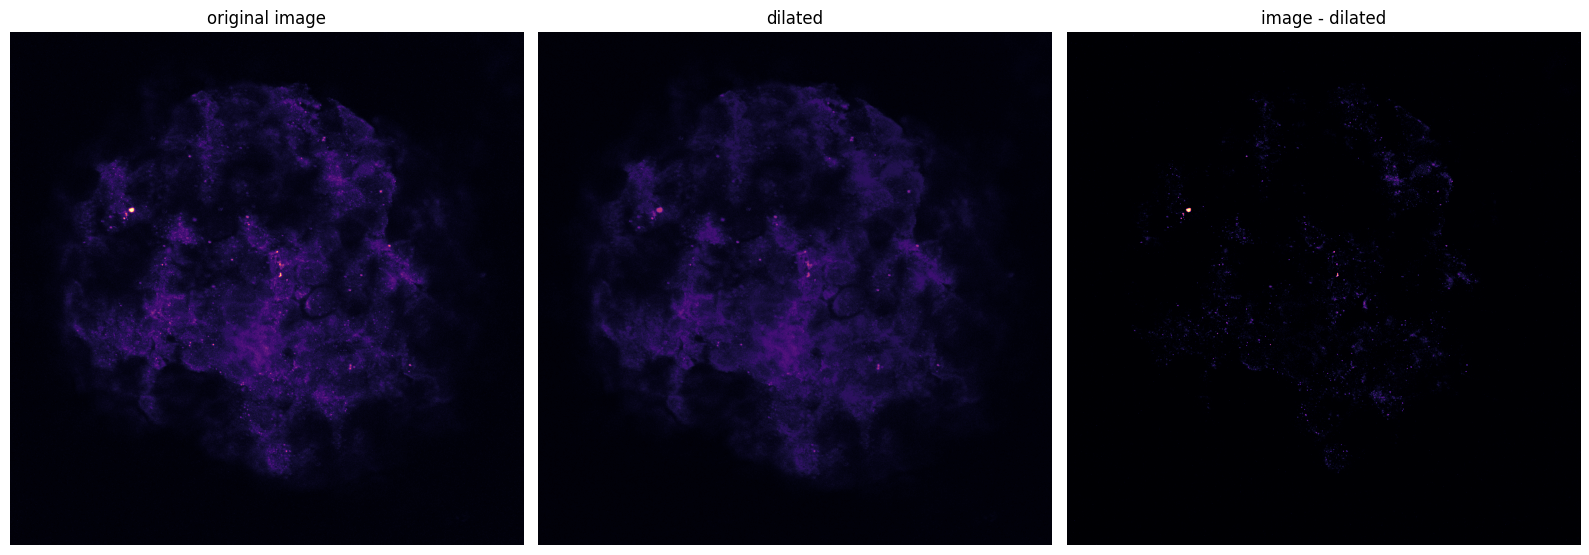

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(16, 8),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(stemness_floats_array[3], cmap='magma')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated[3], vmin=stemness_floats_array[3].min(), vmax=stemness_floats_array[3].max(), cmap='magma')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome[3], cmap='magma')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

In [ ]:
# Saving the before and after images

# # Create a figure with two subplots
# fig, (ax0, ax1) = plt.subplots(nrows=1,
#                                ncols=2,
#                                figsize=(12, 6),  # Adjusted size
#                                sharex=True,
#                                sharey=True)

# # Original Image
# ax0.imshow(stemness_floats_array[3], cmap='magma')
# ax0.set_title('original image')
# ax0.axis('off')

# # Image - Dilated
# ax1.imshow(hdome[3], cmap='magma')
# ax1.set_title('image - dilated')
# ax1.axis('off')

# fig.tight_layout()

# # Save the plot to your computer
# filename = "/content/saved_plot.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)


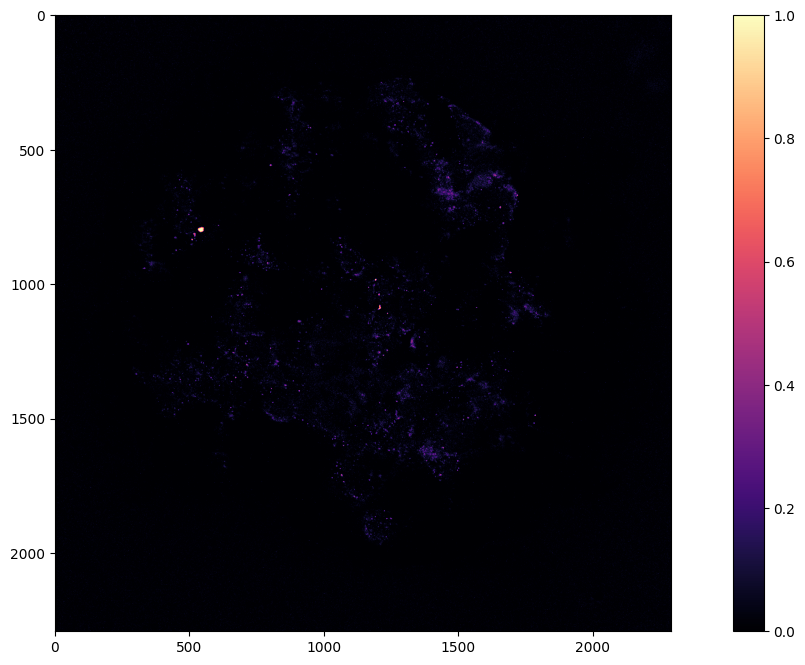

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(hdome_adapteq[3], cmap='magma')
fig.colorbar(plt.cm.ScalarMappable(norm=None, cmap='magma'), ax=ax)


# # Save the plot to your computer BEFORE displaying it
# filename = "/content/saved2_plot.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)


plt.show()  # Display the plot


Mepa que lo mejorcito que puedo obtener es reconstrucción con h=0.5 y luego ecualización adaptativa.

In [ ]:
# We add the filtered layer to the Napari Viewer
if not IN_COLAB:
  viewer.add_image(hdome_adapteq, name='SOX2-filtered', colormap='red', blending='additive');
  # viewer.layers['hdome_adapteq'].name = 'SOX2-filtered'
  print(viewer.layers)

## Nuclei Layer

For this layer we'll do instance segmentation. Esto lo puedo hacer por ahora con imágenes 2D. El esferoide está muy aplastado, parecen ser dos capas de células nomás. De las 9 imágenes, las útiles son la 3, la 4 y la 5. La 3 muestra un grupo de células por encima del resto y la 5 muestra la capa que está debajo. La 4 parece agarrar todo lo mejor posible, así que voy a ir con esa.

In [ ]:
# 0. Converting the original image to float (originally it's a 'uint16')
image_3d = np.copy(nuclei_channel)
image_2d = image_3d[3]

image_normalized = image_3d.astype(np.float32) / 65535.0

# 1. Adaptive Histogram Equalization on the 3D image
image_3d_equalized = exposure.equalize_adapthist(image_3d)

# 2. Extract a 2D slice from the equalized 3D image
image_2d_equalized = image_3d_equalized[3]

# 3. Morphological opening to remove small noise
selem = morphology.disk(2)  # using a disk-shaped structuring element of radius 2
image_2d_opened = morphology.opening(image_2d_equalized, selem)
image_2d_opened = morphology.area_closing(image_2d_opened, area_threshold=150)


(-0.5, 2291.5, 2291.5, -0.5)

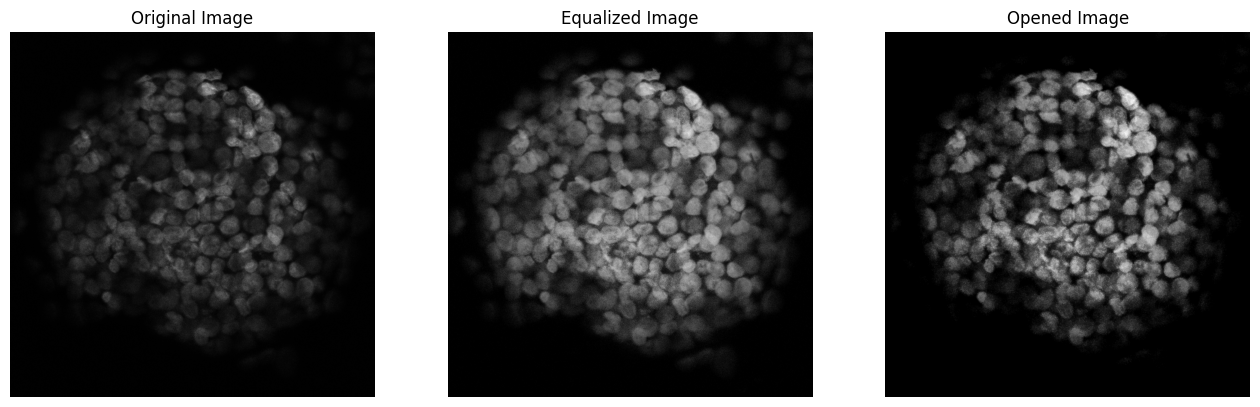

In [ ]:
# Plotting the original, equalized, and opened images
fig, axes = plt.subplots(1, 3, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(image_2d, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(image_2d_equalized, cmap='gray')
ax[1].set_title("Equalized Image")
ax[1].axis('off')

ax[2].imshow(image_2d_opened, cmap='gray')
ax[2].set_title("Opened Image")
ax[2].axis('off')

In [ ]:
# 4. Bilateral Filtering (denoising without bluring edges)
image_opened_bilateral = denoise_bilateral(image_2d_opened, sigma_color=0.05, sigma_spatial=15)


In [ ]:
# 5. Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Perform instance segmentation on the normalized binary image
labels, details = model.predict_instances(image_opened_bilateral)


Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

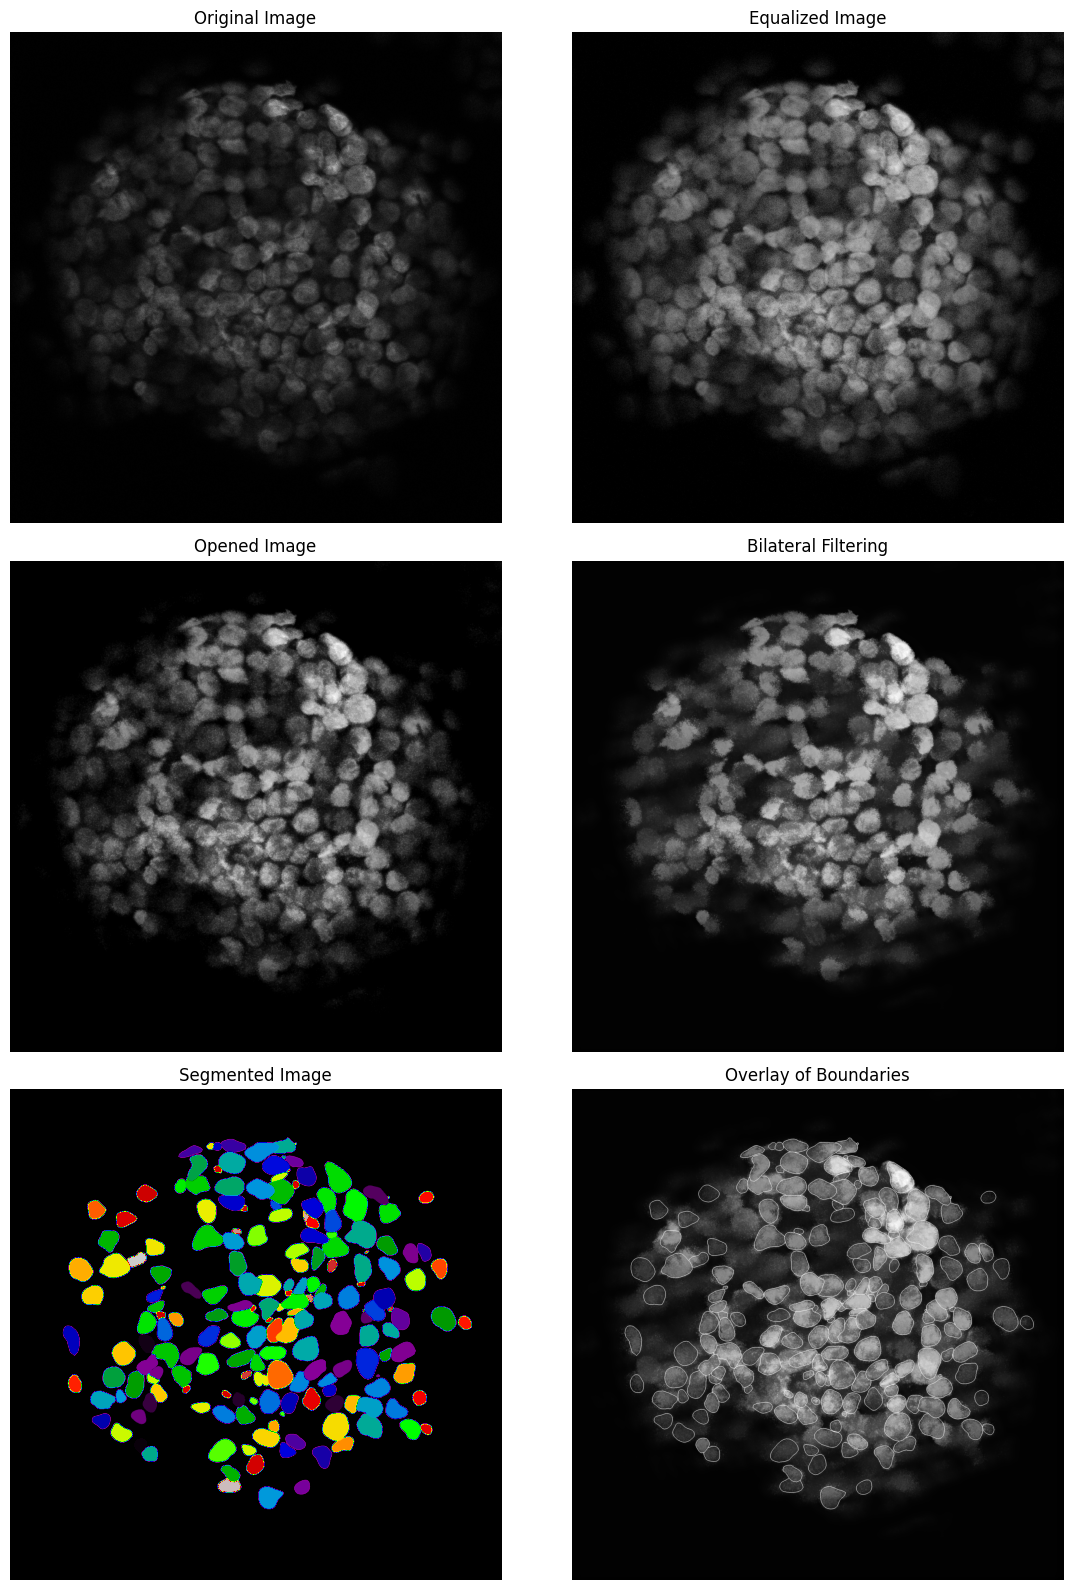

In [ ]:
# Extract boundaries from the labels
boundaries = find_boundaries(labels)

# Overlay boundaries on the opened, filtered image
overlay = np.copy(image_opened_bilateral)
overlay[boundaries] = np.max(image_opened_bilateral)  # setting the boundary pixels to the maximum value of the image for visualization

# ----------------------------------


# Plotting the original, equalized, opened, and segmented images
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
ax = axes.ravel()

ax[0].imshow(image_2d, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(image_2d_equalized, cmap='gray')
ax[1].set_title("Equalized Image")
ax[1].axis('off')

ax[2].imshow(image_2d_opened, cmap='gray')
ax[2].set_title("Opened Image")
ax[2].axis('off')

ax[3].imshow(image_opened_bilateral, cmap='gray')
ax[3].set_title("Bilateral Filtering")
ax[3].axis('off')

ax[4].imshow(labels, cmap='nipy_spectral')
ax[4].set_title("Segmented Image")
ax[4].axis('off')

ax[5].imshow(overlay, cmap='gray')
ax[5].set_title("Overlay of Boundaries")
ax[5].axis('off')

plt.tight_layout()


# # Save the plot to your computer
# filename = "/content/nuclei_processing_vertical.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)


plt.show()



In [ ]:
# ------ COMPARING SEGMENTATIONS ------

# 5. Load pretrained StarDist 2D model for fluorescent images
model = StarDist2D.from_pretrained('2D_versatile_fluo')


# ------ Original -> segmented ------

# Perform instance segmentation on the normalized binary image
or_labels, or_details = model.predict_instances(image_2d)

# Extract boundaries from the labels
or_boundaries = find_boundaries(or_labels)

# Overlay boundaries on the opened, filtered image
or_overlay = np.copy(image_2d)
or_overlay[or_boundaries] = np.max(image_2d)


# ------ Equalized -> segmented ------

# Perform instance segmentation on the normalized binary image
eq_labels, eq_details = model.predict_instances(image_2d_equalized)

# Extract boundaries from the labels
eq_boundaries = find_boundaries(eq_labels)

# Overlay boundaries on the opened, filtered image
eq_overlay = np.copy(image_2d_equalized)
eq_overlay[eq_boundaries] = np.max(image_2d_equalized)


# ------ Opened -> segmented ------

# Perform instance segmentation on the normalized binary image
op_labels, op_details = model.predict_instances(image_2d_opened)

# Extract boundaries from the labels
op_boundaries = find_boundaries(op_labels)

# Overlay boundaries on the opened, filtered image
op_overlay = np.copy(image_2d_opened)
op_overlay[op_boundaries] = np.max(image_2d_opened)



# ------ Bilateral -> segmented ------

# Perform instance segmentation on the normalized binary image
bi_labels, bi_details = model.predict_instances(image_opened_bilateral)

# Extract boundaries from the labels
bi_boundaries = find_boundaries(bi_labels)

# Overlay boundaries on the opened, filtered image
bi_overlay = np.copy(image_opened_bilateral)
bi_overlay[bi_boundaries] = np.max(image_opened_bilateral)
# setting the boundary pixels to the maximum value of the image for visualization


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


base.py (395): Predicting on non-float input... ( forgot to normalize? )


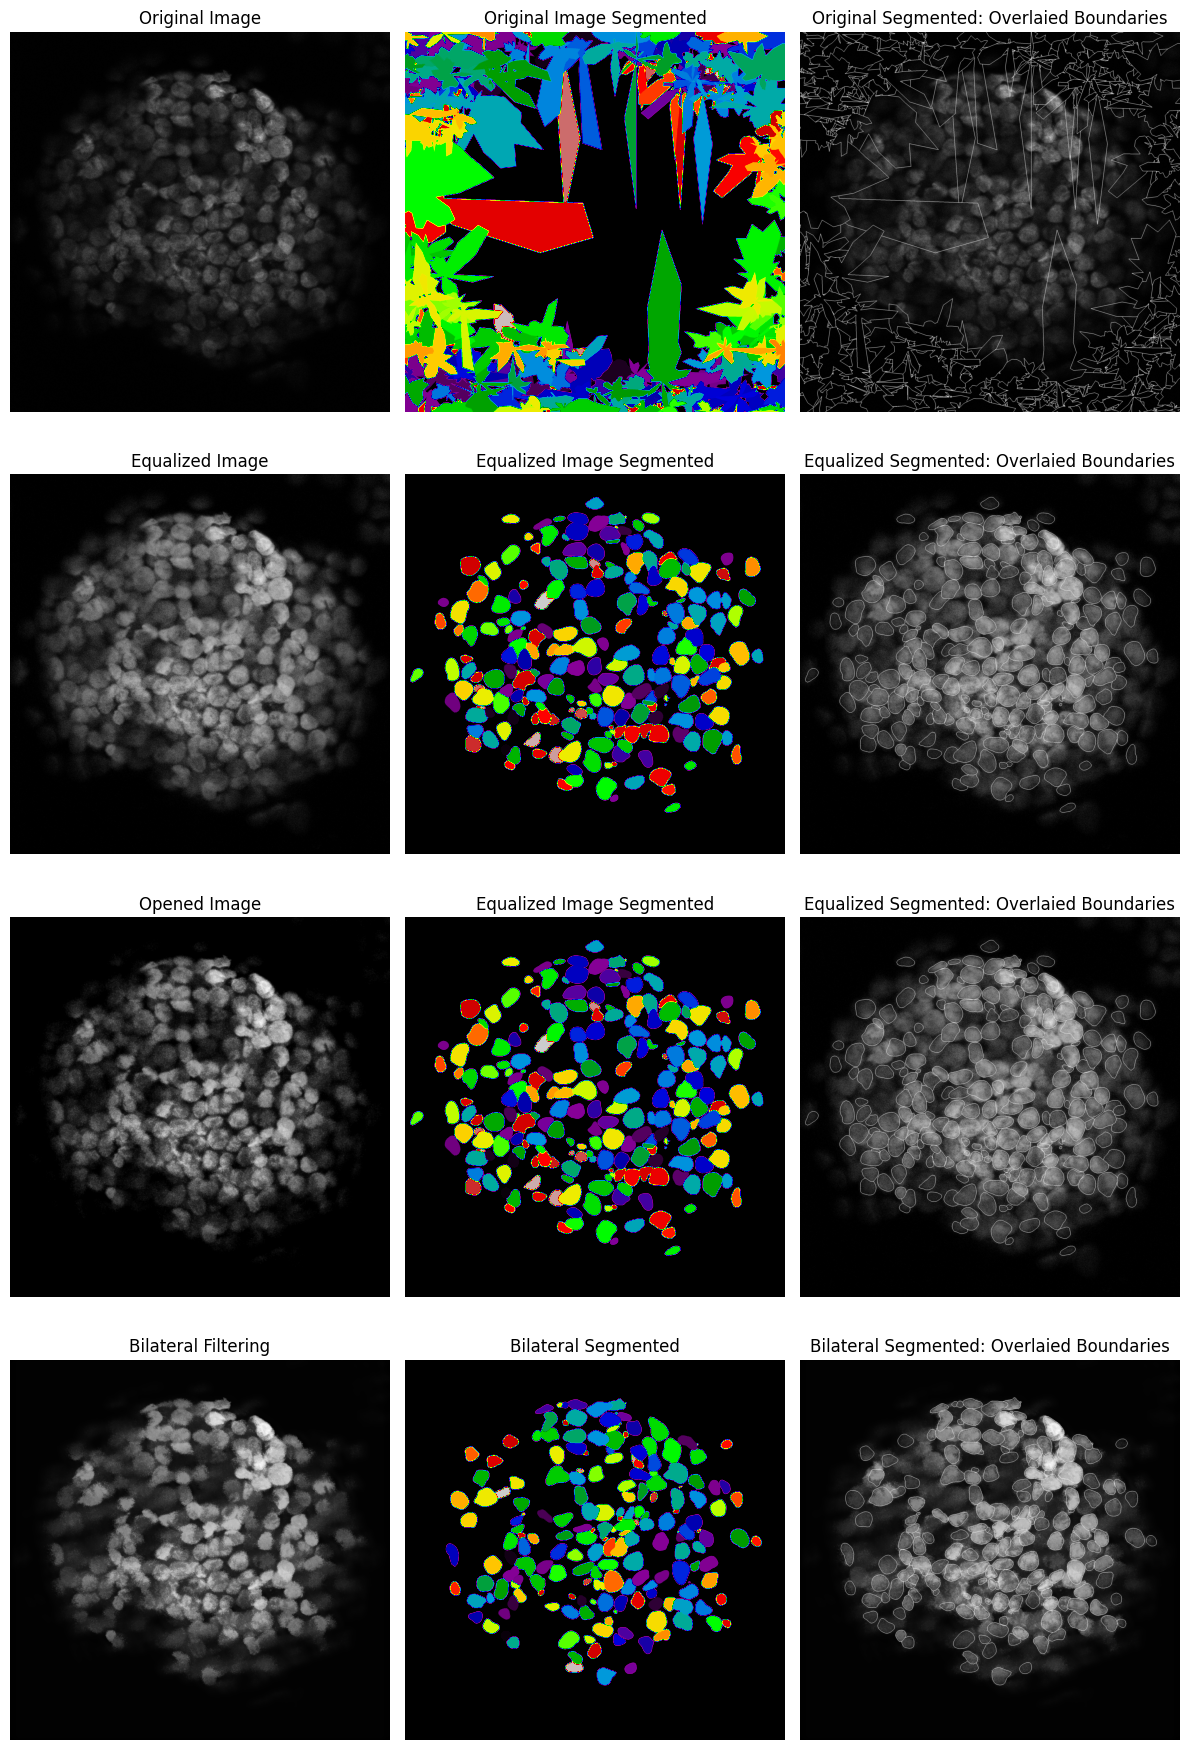

In [ ]:
# ------ Plotting the original, equalized, opened, and segmented images ------
fig, axes = plt.subplots(4, 3, figsize=(12, 18))
ax = axes.ravel()

# ------ Original -> segmented ------

ax[0].imshow(image_2d, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(or_labels, cmap='nipy_spectral')
ax[1].set_title("Original Image Segmented")
ax[1].axis('off')

ax[2].imshow(or_overlay, cmap='gray')
ax[2].set_title("Original Segmented: Overlaied Boundaries")
ax[2].axis('off')

# ------ Equalized -> segmented ------

ax[3].imshow(image_2d_equalized, cmap='gray')
ax[3].set_title("Equalized Image")
ax[3].axis('off')

ax[4].imshow(eq_labels, cmap='nipy_spectral')
ax[4].set_title("Equalized Image Segmented")
ax[4].axis('off')

ax[5].imshow(eq_overlay, cmap='gray')
ax[5].set_title("Equalized Segmented: Overlaied Boundaries")
ax[5].axis('off')

# ------ Opened -> segmented ------

ax[6].imshow(image_2d_opened, cmap='gray')
ax[6].set_title("Opened Image")
ax[6].axis('off')

ax[7].imshow(eq_labels, cmap='nipy_spectral')
ax[7].set_title("Equalized Image Segmented")
ax[7].axis('off')

ax[8].imshow(eq_overlay, cmap='gray')
ax[8].set_title("Equalized Segmented: Overlaied Boundaries")
ax[8].axis('off')

# ------ Bilateral -> segmented ------

ax[9].imshow(image_opened_bilateral, cmap='gray')
ax[9].set_title("Bilateral Filtering")
ax[9].axis('off')

ax[10].imshow(bi_labels, cmap='nipy_spectral')
ax[10].set_title("Bilateral Segmented")
ax[10].axis('off')

ax[11].imshow(bi_overlay, cmap='gray')
ax[11].set_title("Bilateral Segmented: Overlaied Boundaries")
ax[11].axis('off')

plt.tight_layout()
plt.show()

La segmentación de las imágenes abierta y ecualizada, detectan cosas que están más al fondo, fuera del plano focal. Me quedo con la que tiene el filtrado, porque a las otras las voy a segmentar con la slice 4.

---

Armamos un `DataFrame` con las características geométricas.

In [ ]:
#@title Generation of the DataFrame with geometrical properties of segmented objects

spacing = (1.2364633517553391e-7, 1.2364633517553391e-7)  # in meters for (y, x) dimensions

properties = [
    "label", "area", "centroid", "equivalent_diameter", "bbox_area", "convex_area", "filled_area", "major_axis_length",
    "minor_axis_length", "bbox", "weighted_centroid", "coords",
    "eccentricity", "euler_number", "extent",
    "feret_diameter_max", "max_intensity", "mean_intensity", "min_intensity",
    "orientation", "perimeter", "solidity"
]

# Extract the region properties
regions = regionprops_table(labels, intensity_image=image_opened_bilateral, properties=properties) # , spacing=spacing

# Convert the result to a DataFrame
df = pd.DataFrame(regions)
df

# Save the DataFrame to a CSV
# df.to_csv("features.csv", index=False)

label    area   centroid-0   centroid-1  equivalent_diameter  bbox_area  \
0        1  3204.0  1662.641074   607.815855            63.870647     4347.0   
1        2  5083.0  1189.104072   636.635058            80.447975     7020.0   
2        3  3300.0  1452.323939  1065.436364            64.820448     4453.0   
3        4  5203.0  1471.086296  1512.976936            81.392047     7216.0   
4        5  4578.0  1466.881171   652.288554            76.347172     6231.0   
..     ...     ...          ...          ...                  ...        ...   
184    185   805.0   976.858385  1397.991304            32.014963     1258.0   
185    186   936.0   667.054487  1055.739316            34.521764     1215.0   
186    187   932.0   598.084764  1377.718884            34.447921     2016.0   
187    188  5171.0  1854.631986  1020.615935            81.141369     7303.0   
188    189  4019.0   800.010699   591.953471            71.534256     6370.0   

     convex_area  filled_area  major_axis_length  minor_axis_length  ...  \
0         3259.0       3204.0          68.786238          59.820723  ...   
1         5173.0       5083.0          95.232220          68.448353  ...   
2         3371.0       3300.0          70.715113          59.675364  ...   
3         5275.0       5203.0          91.614034          72.756361  ...   
4         4672.0       4578.0          91.330323          64.443021  ...   
..           ...          ...                ...                ...  ...   
184        870.0        805.0          40.926492          26.079088  ...   
185        969.0        936.0          46.539594          25.716896  ...   
186       1122.0        932.0          49.617094          28.355663  ...   
187       5683.0       5171.0         111.049149          60.884924  ...   
188       4271.0       4019.0          97.142431          54.278220  ...   

     eccentricity  euler_number    extent  feret_diameter_max  max_intensity  \
0        0.493649             1  0.737060           71.470274       0.325997   
1        0.695266             1  0.724074           97.948966       0.504318   
2        0.536525             1  0.741073           75.186435       0.589241   
3        0.607706             1  0.721037           93.407708       0.630762   
4        0.708607             1  0.734714           93.770998       0.349929   
..            ...           ...       ...                 ...            ...   
184      0.770684             1  0.639905           42.201896       0.570675   
185      0.833459             1  0.770370           45.891176       0.353829   
186      0.820609             1  0.462302           57.271284       0.455039   
187      0.836301             1  0.708065          109.553640       0.227770   
188      0.829337             1  0.630926           93.621579       0.440425   

     mean_intensity min_intensity  orientation   perimeter  solidity  
0          0.264932      0.016023    -0.344251  211.965512  0.983124  
1          0.378100      0.085399     0.544918  274.592929  0.982602  
2          0.460765      0.189586     0.186678  217.137085  0.978938  
3          0.494673      0.143238    -0.972377  271.563492  0.986351  
4          0.270635      0.067041     0.080902  261.521861  0.979880  
..              ...           ...          ...         ...       ...  
184        0.373405      0.072562     0.609956  114.811183  0.925287  
185        0.178807      0.097310     1.407554  120.083261  0.965944  
186        0.310005      0.103684     0.253947  148.539105  0.830660  
187        0.135792      0.051253     1.541272  303.663997  0.909907  
188        0.254061      0.060043    -1.138815  262.936075  0.940997  

[189 rows x 27 columns]

Como una primera aproximación, en lugar de segmentar usando el canal óptico, hacemos Voronoi con los centroides de los objectos segmentados como puntos (ver [documentación](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html))

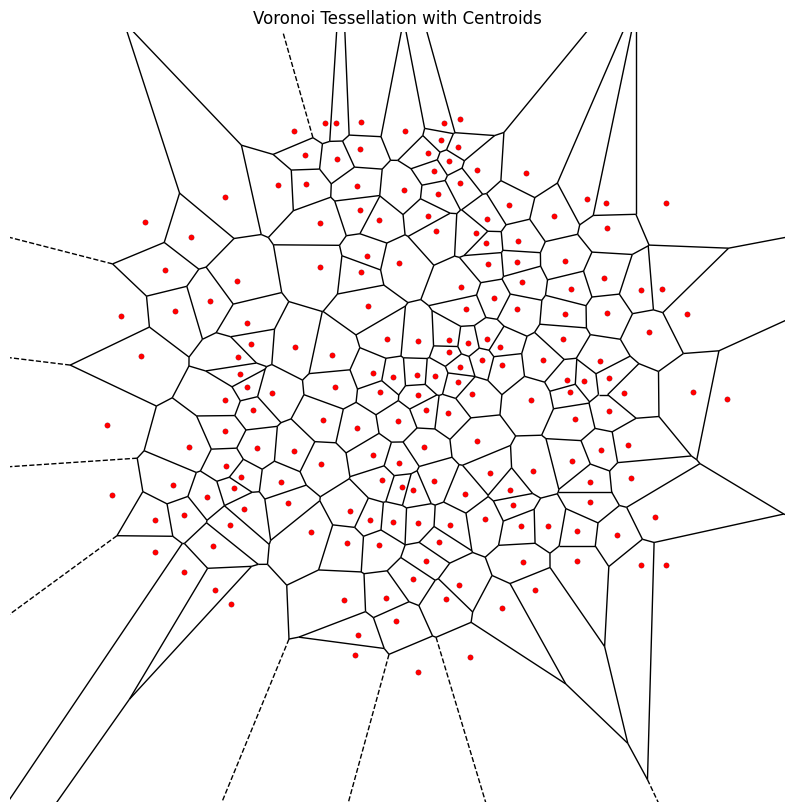

In [ ]:
#@title Voronoi Teselation

# Convert centroids to integer coordinates for seeding
centroids = df[['centroid-0', 'centroid-1']].to_numpy().astype(int)

# Using the centroids as the points for Voronoi, but making sure we're using (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Note the coordinate reversal here
vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(10, 10))
voronoi_plot_2d(vor, ax=ax, show_points=True, show_vertices=False)

# Display the centroids
for (r, c) in centroids:
    ax.plot(c, r, 'r.')  # plot using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # invert y-axis to match image coordinates
ax.set_title('Voronoi Tessellation with Centroids')
plt.axis('off')


# # Save the plot to your computer
# filename = "/content/voronoi_tessellation.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()


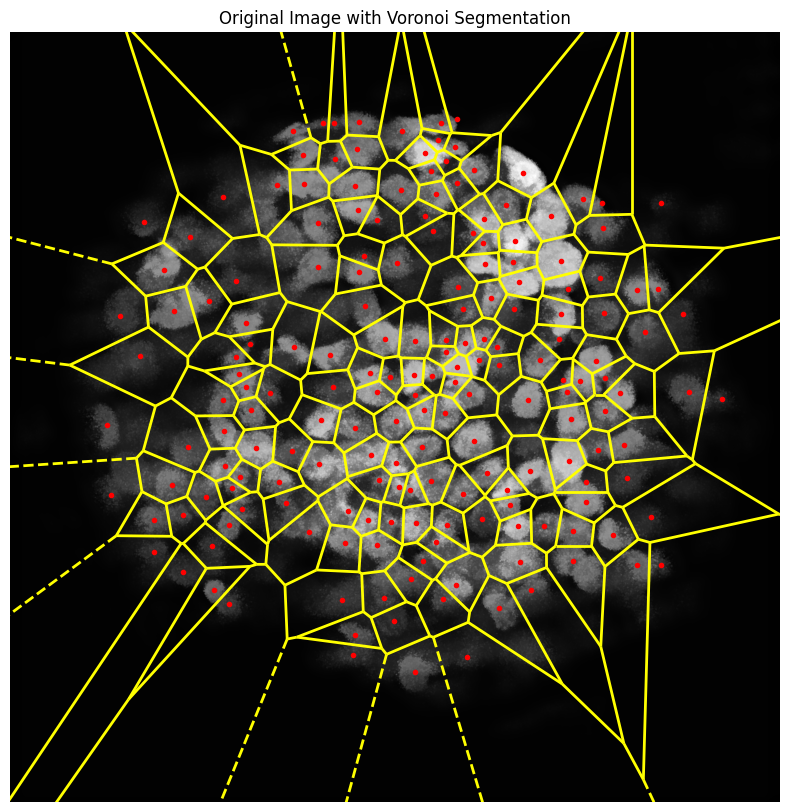

In [ ]:
# -------- Image Teselation Overlay --------

# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'r.')  # Using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Image with Voronoi Segmentation')
plt.axis('off')
plt.show()


El atributo `regions` del objeto `Voronoi` contiene los índices de los vértices que definen cada región (ver [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html)). Luego, el truco está en usar `skimage.draw.polygon`, que te devuelve los pixels de la imagen que están dentro del polígono (ver [docs](https://scikit-image.org/docs/stable/api/skimage.draw.html#skimage.draw.polygon)).

In [ ]:
#@title Counting Fluorescence Intensity in each region
hdome3 = hdome[3]

# Create a blank image for Voronoi segmentation
voronoi_regions = np.zeros_like(hdome3, dtype=int)

# Generate Voronoi regions
points = np.array([(c, r) for r, c in centroids])
vor = Voronoi(points)

intensity_sums = [0] * len(centroids)  # Initialize intensity sums with zeros

for region in vor.regions:
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        if len(polygon) > 2:  # Ensure that we have a valid polygon with more than 2 vertices
            rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], voronoi_regions.shape)

            # Determine which centroid this region belongs to based on proximity
            region_centroid = (np.mean(rr), np.mean(cc))
            idx = np.argmin([distance.euclidean(region_centroid, cent) for cent in centroids])

            voronoi_regions[rr, cc] = idx + 1  # Add 1 to avoid using zero as a label
            intensity_sums[idx] += np.sum(hdome3[rr, cc])  # Update the intensity sum for this region

# Add the intensity sums to the dataframe
df['Fluorescence_Intensity'] = intensity_sums



In [ ]:
df['Fluorescence_Intensity'].min()

0.0

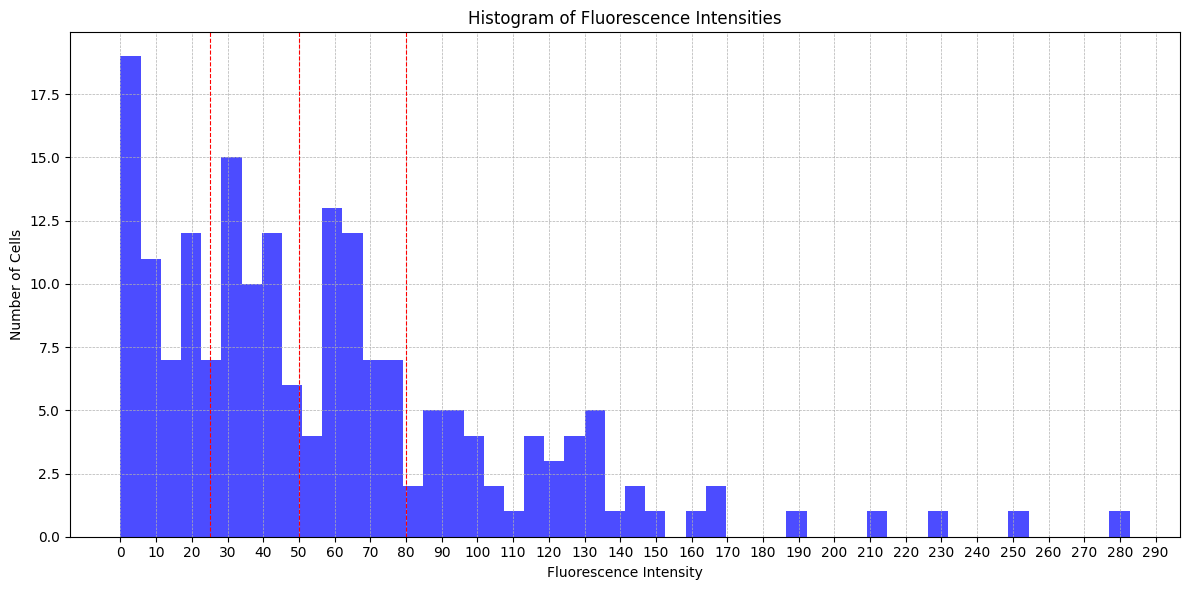

In [ ]:
# Histogram of Fluorescence Intensities
plt.figure(figsize=(12, 6))
plt.hist(df['Fluorescence_Intensity'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Fluorescence Intensities')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Adding vertical lines at x-values 25, 50, and 80
plt.axvline(25, color='red', linestyle='--', linewidth=0.8)
plt.axvline(50, color='red', linestyle='--', linewidth=0.8)
plt.axvline(80, color='red', linestyle='--', linewidth=0.8)

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()


# # Save the plot to your computer
# filename = "/content/fluorescence_intensity_histogram.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)


plt.show()


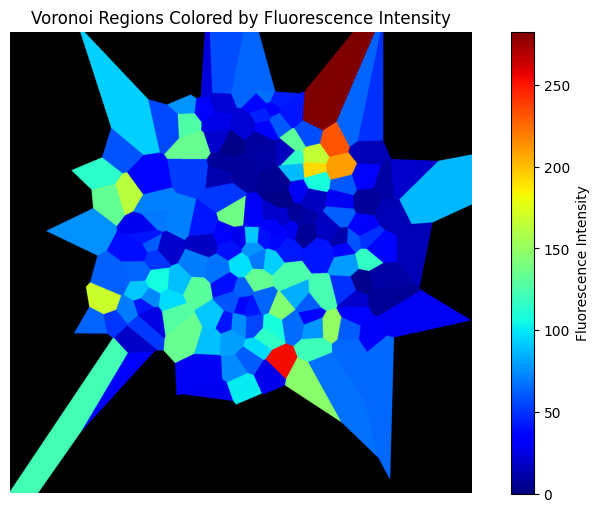

In [ ]:
# ---- Plotting the regions colored by fluorescence intensity ----

# Create an empty image to overlay the Voronoi regions
colored_voronoi = np.zeros(hdome3.shape + (3,), dtype=np.uint8)

# Map the fluorescence intensities to a colormap
norm = mcolors.Normalize(vmin=df['Fluorescence_Intensity'].min(), vmax=df['Fluorescence_Intensity'].max())
colormap = plt.cm.seismic

for point_idx, region_idx in enumerate(vor.point_region):
    region = vor.regions[region_idx]
    if not -1 in region and len(region) > 0:  # Check if the region is not infinite and not empty
        polygon = [vor.vertices[i] for i in region]
        rr, cc = skimage.draw.polygon([p[1] for p in polygon], [p[0] for p in polygon], hdome3.shape)

        # Check if rr and cc are not empty
        if len(rr) > 0 and len(cc) > 0:
            # Get the color corresponding to the fluorescence intensity
            color = colormap(norm(df.at[point_idx, 'Fluorescence_Intensity']))[:3]
            color = tuple(int(c*255) for c in color)

            colored_voronoi[rr, cc] = color

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(colored_voronoi)
ax.set_title('Voronoi Regions Colored by Fluorescence Intensity')
ax.axis('off')

# Add the colorbar using a ScalarMappable object
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Fluorescence Intensity')


# # Save the plot to your computer
# filename = "/content/voronoi_colored_fluorescence.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)


plt.show()


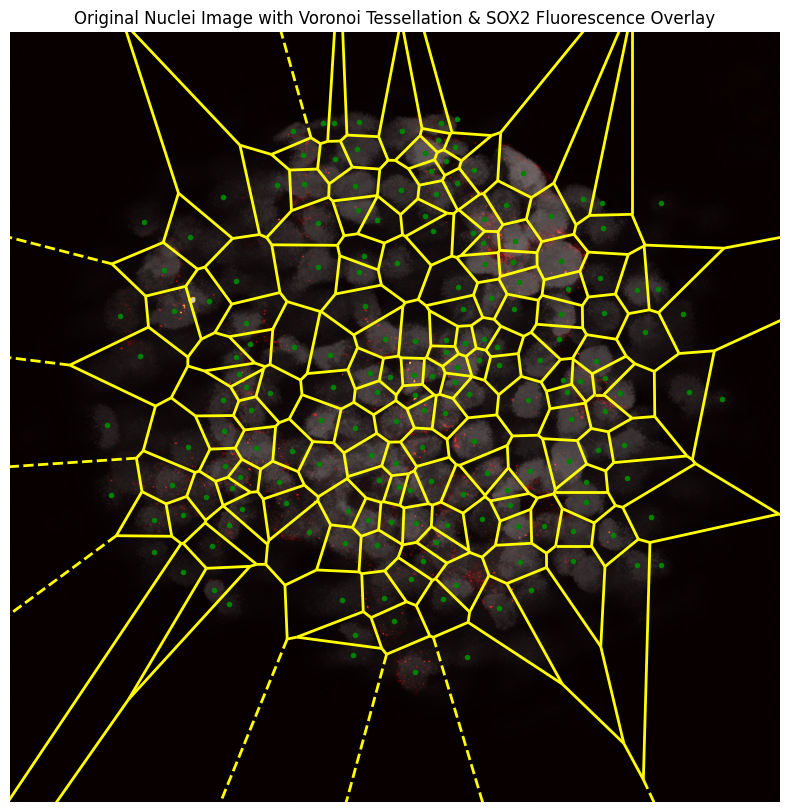

In [ ]:
#@title Regions, Nuclei and SOX2 Overlay
# Using the centroids as the points for Voronoi, ensuring (x, y) coordinates
points = np.array([(c, r) for r, c in centroids])  # Coordinate reversal
vor = Voronoi(points)

# Start the plot and display the original image
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_opened_bilateral, cmap='gray')

# Overlay the Voronoi diagram without the original Voronoi points
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='yellow', line_width=2)

# Overlay the fluorescence channel using a colormap. Here, I assume fluorescence_image represents your fluorescence channel.
ax.imshow(hdome[3], cmap='hot', alpha=0.6)  # Adjust alpha for desired transparency of overlay

# Display the centroids on top
for (r, c) in centroids:
    ax.plot(c, r, 'g.')  # Using (x, y) convention

ax.set_xlim([0, labels.shape[1]])
ax.set_ylim([labels.shape[0], 0])  # Invert y-axis to match image coordinates
ax.set_title('Original Nuclei Image with Voronoi Tessellation & SOX2 Fluorescence Overlay')
plt.axis('off')


# # Save the plot to your computer
# filename = "/content/nuclei_voronoi_sox2.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)


plt.show()

### Stemnes criterion
Looking at the histogram, there are some values that seem more reasonable when considering where to set the threshold. (We think that the histogram reflects a bimodal distribution somehow.) Here, we count the number of stem cells according to some of this threshold values.

In [ ]:
stemness_df = df[['label', 'area', 'Fluorescence_Intensity', 'centroid-0', 'centroid-1']].copy()

stemness_df.loc[:, 'fluorescence>25'] = stemness_df['Fluorescence_Intensity'] > 25
stemness_df.loc[:, 'fluorescence>50'] = stemness_df['Fluorescence_Intensity'] > 50
stemness_df.loc[:, 'fluorescence>80'] = stemness_df['Fluorescence_Intensity'] > 80

stemness_df

label    area  Fluorescence_Intensity   centroid-0   centroid-1  \
0        1  3204.0               31.786206  1662.641074   607.815855   
1        2  5083.0               63.255543  1189.104072   636.635058   
2        3  3300.0               41.725963  1452.323939  1065.436364   
3        4  5203.0               77.387800  1471.086296  1512.976936   
4        5  4578.0               51.567918  1466.881171   652.288554   
..     ...     ...                     ...          ...          ...   
184    185   805.0               28.262028   976.858385  1397.991304   
185    186   936.0                7.395071   667.054487  1055.739316   
186    187   932.0               16.027611   598.084764  1377.718884   
187    188  5171.0                0.000000  1854.631986  1020.615935   
188    189  4019.0              162.927008   800.010699   591.953471   

     fluorescence>25  fluorescence>50  fluorescence>80  
0               True            False            False  
1               True             True            False  
2               True            False            False  
3               True             True            False  
4               True             True            False  
..               ...              ...              ...  
184             True            False            False  
185            False            False            False  
186            False            False            False  
187            False            False            False  
188             True             True             True  

[189 rows x 8 columns]

In [ ]:
stemness_df['fluorescence>25'].loc[stemness_df['fluorescence>25']==True].count()

139

In [ ]:
stemness_df['fluorescence>25'].loc[stemness_df['fluorescence>25']==False].count()

50

In [ ]:
# Number of CSC according to diferent criteria
S_25 = stemness_df['fluorescence>25'].loc[stemness_df['fluorescence>25']==True].count()
S_50 = stemness_df['fluorescence>50'].loc[stemness_df['fluorescence>50']==True].count()
S_80 = stemness_df['fluorescence>80'].loc[stemness_df['fluorescence>80']==True].count()

print(f'Number S of stem cells, considering that  Fluorescence_Intensity > V  implies that the cell of that region is a stem cell.')
print('----------------------------------------')
print(f'V=25 => S={S_25} => CSC fraction = {S_25/189.0}')
print(f'V=50 => S={S_50} => CSC fraction = {S_50/189.0}')
print(f'V=80 => S={S_80} => CSC fraction = {S_80/189.0}')

Number S of stem cells, considering that  Fluorescence_Intensity > V  implies that the cell of that region is a stem cell.
----------------------------------------
V=25 => S=139 => CSC fraction = 0.7354497354497355
V=50 => S=92 => CSC fraction = 0.48677248677248675
V=80 => S=46 => CSC fraction = 0.24338624338624337


---

Let's try doing clustering to identify the two groups.

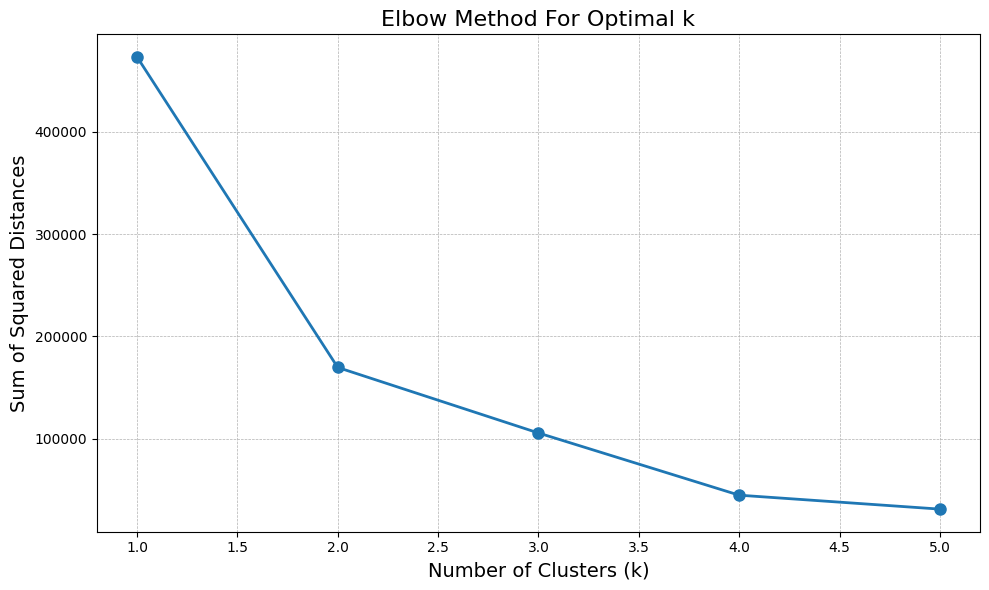

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Extract fluorescence intensity values from the DataFrame
fluorescence_intensities = df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Calculate sum of squared distances (SSD) for different values of k
ssd = []
range_n_clusters = range(1, 6)

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=42)
    kmeans.fit(fluorescence_intensities)
    ssd.append(kmeans.inertia_)

# Plot the SSD values against k to visualize the elbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Sum of Squared Distances', fontsize=14)
plt.title('Elbow Method For Optimal k', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The elbow plot shows a great decrease in variance when using two clusters with respect to the rest (as we wanted). We'll check this again later. Let's now add the result of the clustering to the `DataFrame`.

In [ ]:
from sklearn.cluster import KMeans

# 1. Fit the K-means clustering with k=2
X = df['Fluorescence_Intensity'].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=2)
df['k_means_stemness'] = kmeans.fit_predict(X)

# 2. Identify the centroids and label corresponding to higher and lower intensity
low_intensity_centroid = kmeans.cluster_centers_.argmin()
high_intensity_centroid = kmeans.cluster_centers_.argmax()

# 3. Reassign the labels based on centroid values
df['k_means_stemness'] = df['k_means_stemness'].replace({low_intensity_centroid: 0, high_intensity_centroid: 1})

# The same code can be adapted for the other methods if required


_kmeans.py (870): The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [ ]:
df[['label', 'k_means_stemness']].head()  # Display the first few rows to verify the new column


label  k_means_stemness
0      1                 1
1      2                 1
2      3                 1
3      4                 1
4      5                 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

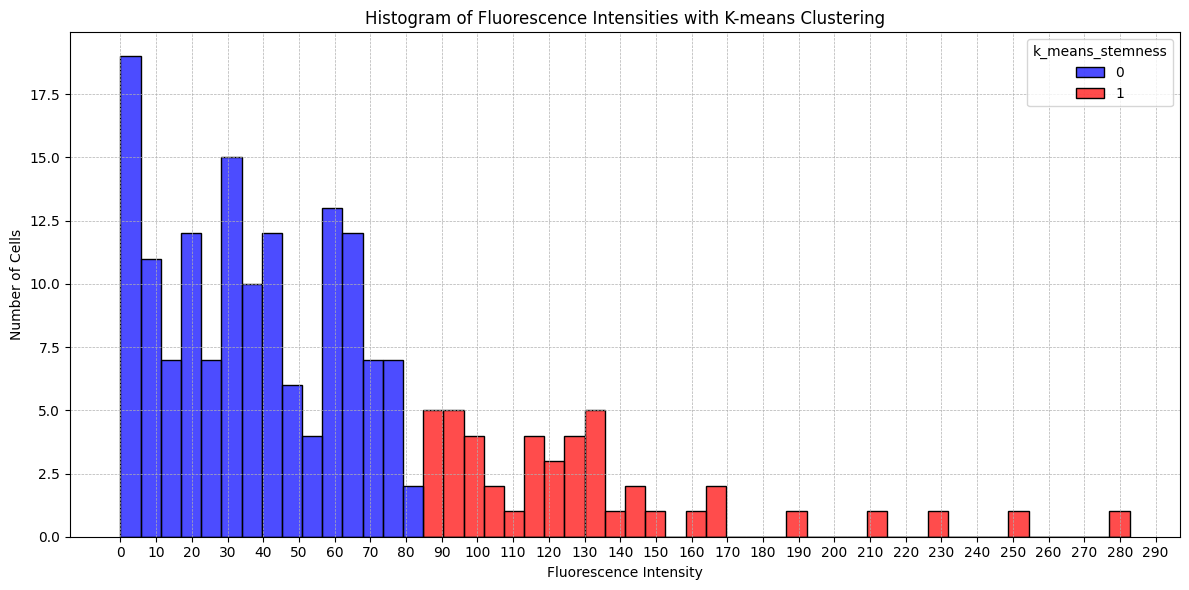

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='k_means_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with K-means Clustering')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_K-means_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()



This is not what we expected, but the bimodal we imagined will more likely be obtained by using a gaussian mixture. Let's first double check the number of cluters.

In [ ]:
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Filter out regions with Fluorescence_Intensity > 180
filtered_df = df[df['Fluorescence_Intensity'] <= 180]

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Estimate bandwidth for Mean Shift
bandwidth = estimate_bandwidth(X, quantile=0.2)  # You can adjust the quantile parameter if needed

# Perform Mean Shift clustering
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

# Get the number of clusters and cluster centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

n_clusters_ = len(np.unique(labels))

print(f"Number of estimated clusters: {n_clusters_}")



Number of estimated clusters: 5


Well, that's too bad. Let's see what GMM says about this.

In [ ]:
from sklearn.mixture import GaussianMixture

# Filter out regions with Fluorescence_Intensity > 180
# filtered_df = df[df['Fluorescence_Intensity'] <= 180]

# Reshape the Fluorescence_Intensity data for clustering
# X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)
X = df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)

# Get the clustering labels
labels = gmm.predict(X)

# Assign the labels to the filtered dataframe
# filtered_df['GMM_stemness'] = labels
df['GMM_stemness'] = labels

# Map the GMM_stemness labels back to the original df
# df['GMM_stemness'] = df.index.map(filtered_df['GMM_stemness'].to_dict())
df['GMM_stemness'] = df.index.map(df['GMM_stemness'].to_dict())



In [ ]:
df[['label', 'GMM_stemness']]

label  GMM_stemness
0        1             0
1        2             0
2        3             0
3        4             0
4        5             0
..     ...           ...
184    185             0
185    186             0
186    187             0
187    188             0
188    189             1

[189 rows x 2 columns]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

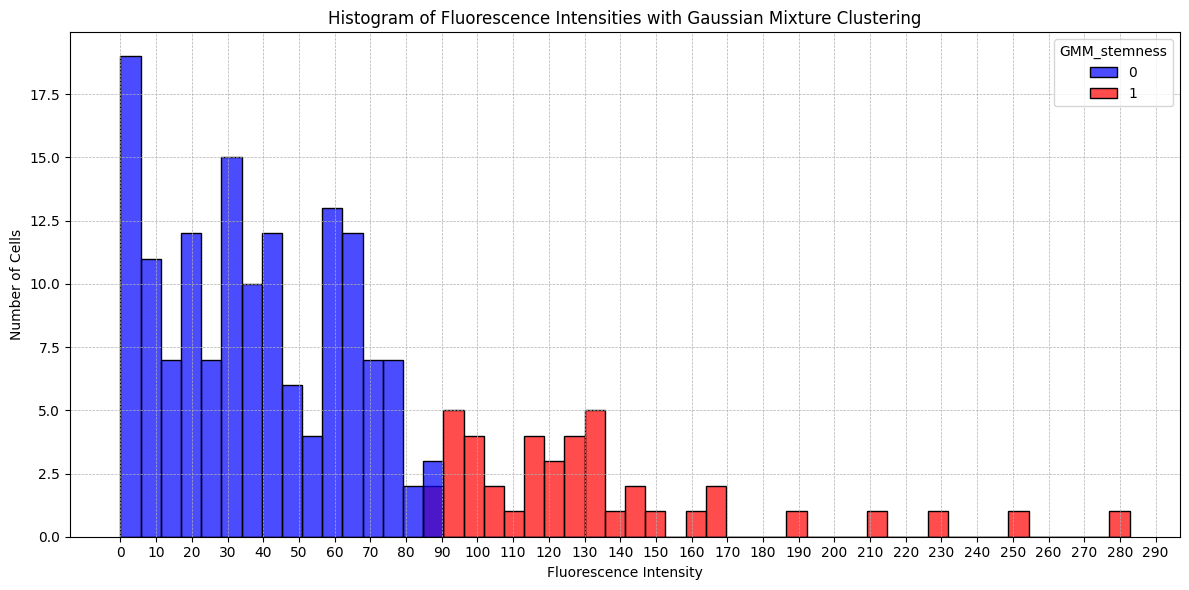

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='GMM_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

Quizás estamos demasiado sesgados por los valores extremos, veamos que pasa si los filtramos.

In [ ]:
from sklearn.mixture import GaussianMixture

# Filter out regions with Fluorescence_Intensity <= 180
filtered_df = df[df['Fluorescence_Intensity'] <= 180].copy()  # Use copy() to ensure we're working on a copy

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform GMM clustering with k=2
gmm = GaussianMixture(n_components=2)
gmm.fit(X)


# Get the clustering labels
labels = gmm.predict(X)

# Compute the mean fluorescence intensity for each cluster
cluster_means = np.array([filtered_df['Fluorescence_Intensity'][labels == i].mean() for i in np.unique(labels)])

# Identify the labels of the clusters with higher and lower mean intensities
label_higher_intensity = cluster_means.argmax()
label_lower_intensity = cluster_means.argmin()

# Replace labels to ensure cluster with higher mean intensity is labeled 1 and the other as 0
labels[labels == label_higher_intensity] = 2  # Use 2 as a temporary label to avoid confusion during replacement
labels[labels == label_lower_intensity] = 0
labels[labels == 2] = 1  # Finally replace temporary label 2 with 1

# Assign the corrected labels to the filtered dataframe
filtered_df.loc[:, 'filtered_GMM_stemness'] = labels

# Map the GMM_stemness labels back to the original df using the recommended approach
df[df.columns[df.columns.get_loc('filtered_GMM_stemness')]] = df.index.map(filtered_df['filtered_GMM_stemness'].to_dict())

# Set the values to 1 where Fluorescence_Intensity > 180
df.loc[df['Fluorescence_Intensity'] > 180, 'filtered_GMM_stemness'] = 1


<ipython-input-140-f123931c3d16> (30): In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [ ]:
df[['label', 'Fluorescence_Intensity', 'filtered_GMM_stemness']].loc[df['Fluorescence_Intensity']>50].loc[df['Fluorescence_Intensity']<60].sort_values(by='Fluorescence_Intensity')

label  Fluorescence_Intensity  filtered_GMM_stemness
45      46               50.244923                    0.0
57      58               50.257206                    0.0
4        5               51.567918                    0.0
98      99               51.954932                    0.0
46      47               55.025910                    0.0
107    108               55.431006                    0.0
106    107               57.277554                    1.0
24      25               57.416388                    1.0
169    170               58.638659                    1.0
42      43               58.927192                    1.0
181    182               59.514534                    1.0
171    172               59.797459                    1.0
165    166               59.973182                    1.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

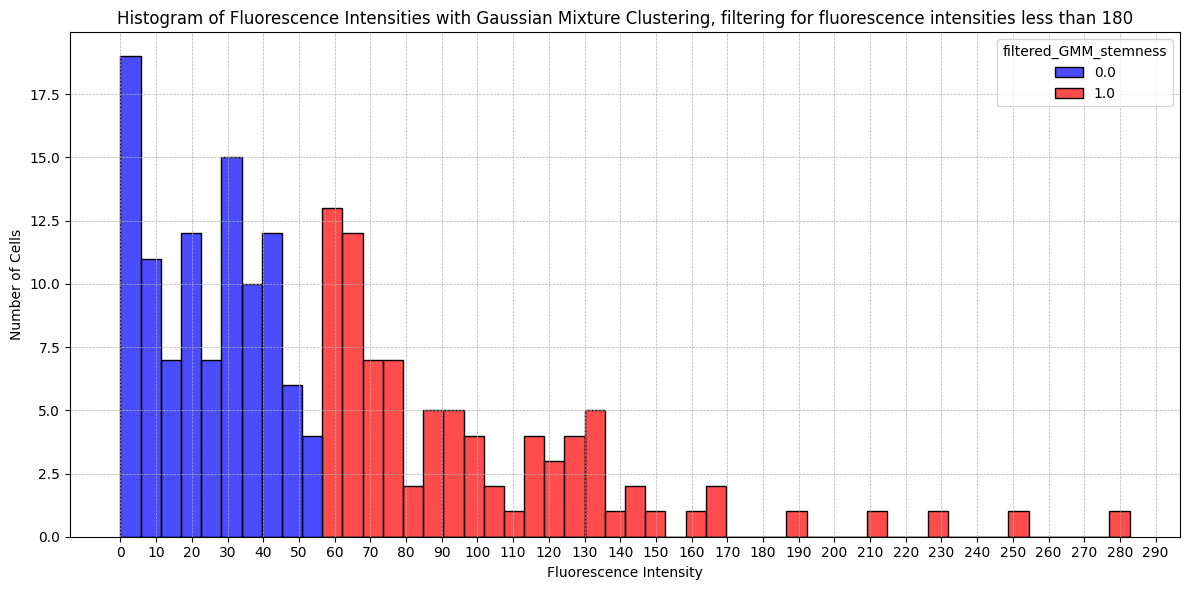

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='filtered_GMM_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with Gaussian Mixture Clustering, filtering for fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# Save the plot to your computer
filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
plt.savefig(filename)

# To download the file to your local machine from Colab
from google.colab import files
files.download(filename)



plt.show()

In [ ]:
# Count the number of 1s for each label
k_means_stemness_ones = df['k_means_stemness'].sum()
GMM_stemness_ones = df['GMM_stemness'].sum()
filtered_GMM_stemness_ones = df['filtered_GMM_stemness'].sum()

print(f"Number of 1s in k_means_stemness: {k_means_stemness_ones}")
print(f"Number of 1s in GMM_stemness: {GMM_stemness_ones}")
print(f"Number of 1s in filtered_GMM_stemness: {filtered_GMM_stemness_ones}")


Number of 1s in k_means_stemness: 45
Number of 1s in GMM_stemness: 42
Number of 1s in filtered_GMM_stemness: 86.0


Cambia mucho si filtro los “atípicos”. Veamos si esto también pasa en K-means.

In [ ]:
from sklearn.cluster import KMeans

# Filter out regions with Fluorescence_Intensity < 180
filtered_df = df[df['Fluorescence_Intensity'] <= 180].copy()  # Use copy() to ensure we're working on a new dataframe

# Reshape the Fluorescence_Intensity data for clustering
X = filtered_df['Fluorescence_Intensity'].values.reshape(-1, 1)

# Perform K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
filtered_df['filtered_k_means_stemness'] = kmeans.fit_predict(X)

# Ensure the cluster with lower mean intensity gets label 0 and the other label 1
cluster_centers = kmeans.cluster_centers_.flatten()
if cluster_centers[0] > cluster_centers[1]:
    # Swap labels
    filtered_df['filtered_k_means_stemness'] = filtered_df['filtered_k_means_stemness'].map({0: 1, 1: 0})

# Map the filtered_k_means_stemness label back to the original df
df['filtered_k_means_stemness'] = df.index.map(filtered_df['filtered_k_means_stemness'].to_dict())

# Set values to 1 where Fluorescence_Intensity > 180
df.loc[df['Fluorescence_Intensity'] > 180, 'filtered_k_means_stemness'] = 1



_kmeans.py (870): The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


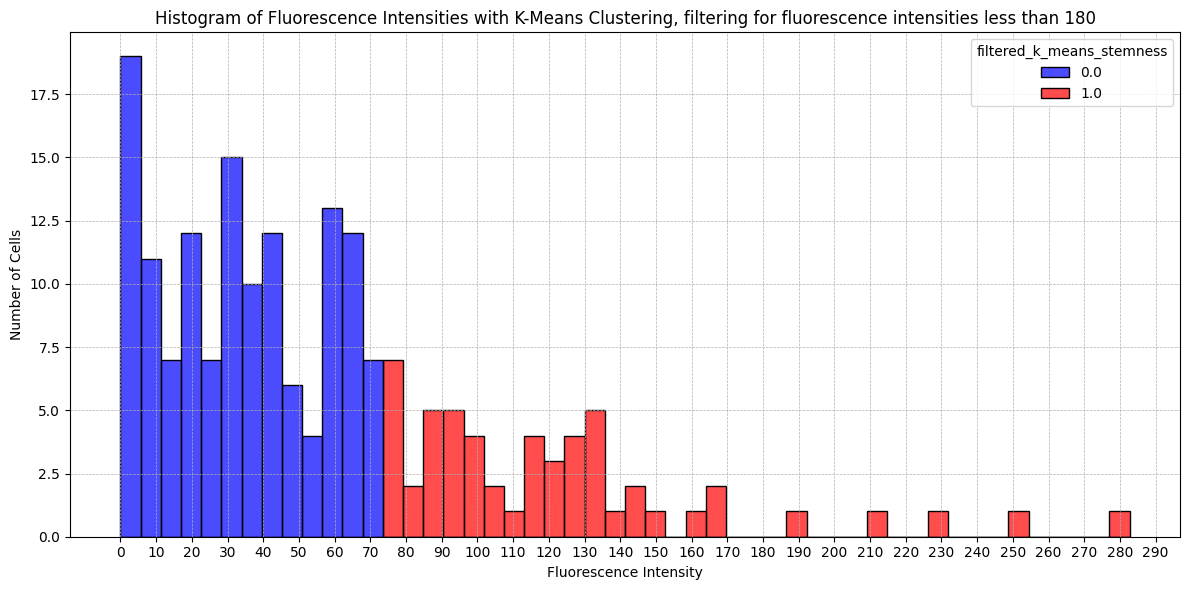

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df, x='Fluorescence_Intensity', hue='filtered_k_means_stemness', bins=50, palette=['blue', 'red'], element='bars', stat='count', common_norm=False, alpha=0.7)

# Plot customization to resemble the original plot
plt.title('Histogram of Fluorescence Intensities with K-Means Clustering, filtering for fluorescence intensities less than 180')
plt.xlabel('Fluorescence Intensity')
plt.ylabel('Number of Cells')

# Set x-ticks starting from 0 and every 10 units
xmax = plt.xlim()[1]  # Get the current maximum xlim value
plt.xticks(np.arange(0, xmax+1, 10))

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()



# # Save the plot to your computer
# filename = "/content/histogram_GMM-means-filtered-intensity<180_clustering.png"  # Path to save the plot in Colab's virtual environment
# plt.savefig(filename)

# # To download the file to your local machine from Colab
# from google.colab import files
# files.download(filename)



plt.show()

In [ ]:
# Let's count again the number of 1s for each label
k_means_stemness_ones = df['k_means_stemness'].sum()
GMM_stemness_ones = df['GMM_stemness'].sum()
filtered_GMM_stemness_ones = df['filtered_GMM_stemness'].sum()
filtered_k_means_stemness_ones = df['filtered_k_means_stemness'].sum()

print(f"Number of 1s in k_means_stemness: {k_means_stemness_ones}")
print(f"Number of 1s in GMM_stemness: {GMM_stemness_ones}")
print(f"Number of 1s in filtered_GMM_stemness: {filtered_GMM_stemness_ones}")
print(f"Number of 1s in filtered_k_means_stemness: {filtered_k_means_stemness_ones}")

print('--------------')
print('For the filtered GMM:')
print(f'V=56 => S={filtered_GMM_stemness_ones} => CSC fraction = {filtered_GMM_stemness_ones/189.0}')


Number of 1s in k_means_stemness: 45
Number of 1s in GMM_stemness: 42
Number of 1s in filtered_GMM_stemness: 86.0
Number of 1s in filtered_k_means_stemness: 54.0
--------------
For the filtered GMM:
V=56 => S=86.0 => CSC fraction = 0.455026455026455


## Optic layer

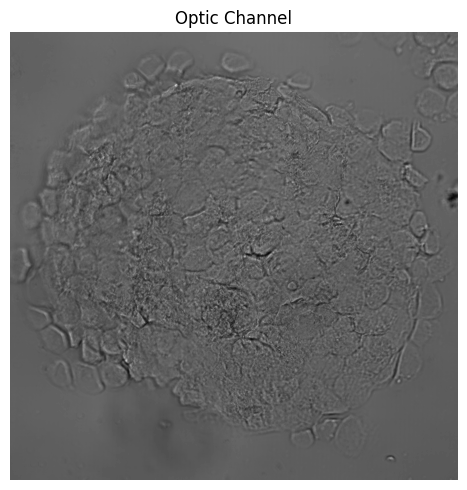

In [ ]:
# Plotting the overlay
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(optic_channel[3], cmap='gray')

# ax.set_title("Original with Overlay")
# ax.set_title("Equalized with Overlay")
ax.set_title("Optic Channel")

ax.axis('off')

plt.tight_layout()
plt.show()


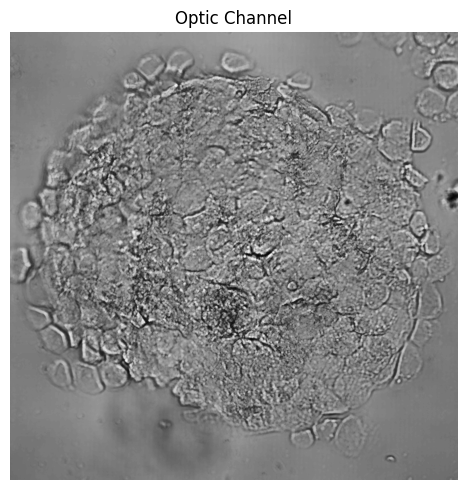

In [ ]:
# 1. Histogram equalization on the 3D image
image_3d = np.copy(viewer.layers['optic_channel'].data)

# Adaptive Histogram Equalization
image_3d_equalized = exposure.equalize_adapthist(image_3d)

# 2. Extract a 2D slice from the equalized 3D image
image_2d_equalized = image_3d_equalized[3]

# Plotting the overlay
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image_2d_equalized, cmap='gray')
ax.set_title("Optic Channel")
ax.axis('off')

plt.tight_layout()
plt.show()


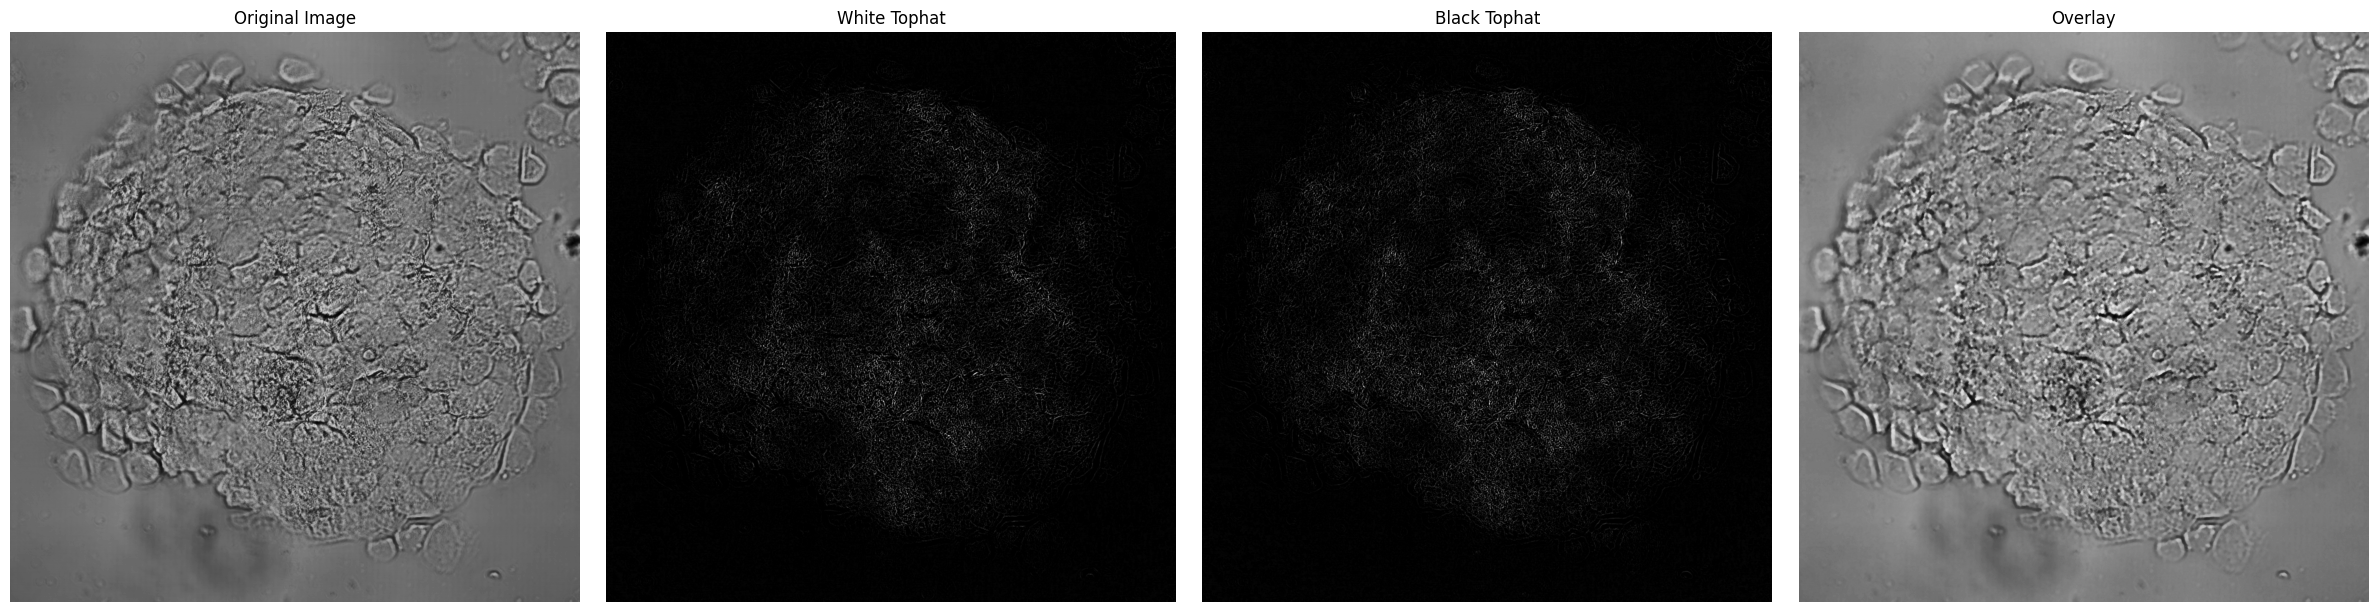

In [ ]:
from skimage.morphology import white_tophat, black_tophat, disk

# Define the structuring element
selem = disk(3)  # You can adjust the radius based on the scale of features you're targeting

# Apply the white tophat operation
image_2d_white_tophat = white_tophat(image_2d_equalized, selem)

# Apply the black tophat operation
image_2d_black_tophat = black_tophat(image_2d_equalized, selem)

# Plotting the original, equalized, white tophat, and black tophat images
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
ax = axes.ravel()

ax[0].imshow(image_2d_equalized, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(image_2d_white_tophat, cmap='gray')
ax[1].set_title("White Tophat")
ax[1].axis('off')

ax[2].imshow(image_2d_black_tophat, cmap='gray')
ax[2].set_title("Black Tophat")
ax[2].axis('off')

# Reducing noise with white and black tophat
denoised = image_2d_equalized - image_2d_white_tophat + image_2d_black_tophat
ax[3].imshow(denoised, cmap='gray')
ax[3].set_title("Overlay")
ax[3].axis('off')

plt.tight_layout()
plt.show()
